download: `wget -r -N -c -np --user harry123fewas --ask-password https://physionet.org/files/mimiciv/3.1/`

unzip

In [ ]:
# Run shell commands in Jupyter notebook to unzip the MIMIC-IV dataset
# Define the base path
mimic_path = "physionet.org/files/mimiciv/3.1/"

# Create directories for unzipped files

os.mkdir( -p {mimic_path}unzipped/hosp)
os.mkdir(-p {mimic_path}unzipped/icu)

# Check disk space before proceeding
print("Checking available disk space:")
!df -h $(dirname {mimic_path})

# Unzip files from the hosp directory
print("\nUnzipping hosp files...")
import os
hosp_files = !ls {mimic_path}hosp/*.gz
for file in hosp_files:
    base = os.path.basename(file).replace('.gz', '')
    output_file = f"{mimic_path}unzipped/hosp/{base}"
    print(f"Unzipping {file} to {output_file}")
    !gunzip -c {file} > {output_file}

# Unzip files from the icu directory
print("\nUnzipping icu files...")
icu_files = !ls {mimic_path}icu/*.gz
for file in icu_files:
    base = os.path.basename(file).replace('.gz', '')
    output_file = f"{mimic_path}unzipped/icu/{base}"
    print(f"Unzipping {file} to {output_file}")
    !gunzip -c {file} > {output_file}

print("\nUnzipping complete!")

# List the unzipped files to verify
print("\nUnzipped hosp files:")
!ls -lh {mimic_path}unzipped/hosp/

print("\nUnzipped icu files:")
!ls -lh {mimic_path}unzipped/icu/

mkdir: /home/ren.hang: Operation not supported
mkdir: /home/ren.hang: Operation not supported
Checking available disk space:
df: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv: No such file or directory

Unzipping hosp files...
Unzipping zsh:1: no matches found: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/hosp/*.gz to /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/hosp/*
zsh:1: no matches found: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/hosp/*.gz

Unzipping icu files...
Unzipping zsh:1: no matches found: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/o

delete download files, only keep unzipped ones

In [2]:
# Define the base path
mimic_path = "/home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/"

# Check current disk usage
print("Current disk usage:")
!du -sh {mimic_path}

# Verify that unzipped files exist and are accessible
print("\nVerifying unzipped files exist:")
!ls -la {mimic_path}unzipped/hosp/ | wc -l
!ls -la {mimic_path}unzipped/icu/ | wc -l

# Remove original compressed files from hosp directory
print("\nRemoving original compressed files from hosp directory...")
!rm {mimic_path}hosp/*.gz

# Remove original compressed files from icu directory
print("\nRemoving original compressed files from icu directory...")
!rm {mimic_path}icu/*.gz

# Check disk usage after deletion
print("\nDisk usage after deletion:")
!du -sh {mimic_path}

# Check your overall disk quota
print("\nCurrent disk quota:")
!du -sh /home/ren.hang
!quota -s

Current disk usage:
du: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/: No such file or directory

Verifying unzipped files exist:
ls: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/hosp/: No such file or directory
       0
ls: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/icu/: No such file or directory
       0

Removing original compressed files from hosp directory...
zsh:1: no matches found: /home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/hosp/*.gz

Removing original compressed files from icu directory...
zsh:1: no matches found: /home/ren.hang/ondemand/data/sys/dash

## A1: Hyponatremia Patient Cohort Identification
In this analysis, we identify the subset of ICU patients with hyponatremia by processing the first 100 M rows from the MIMIC-IV `chartevents` table. We focus on serum sodium measurements by filtering for known itemids and valid values (80–180 mEq/L). Patients are classified into two groups:
- **Hyponatremia:** Patients with at least one serum sodium measurement below 135 mEq/L.
- **Severe Hyponatremia:** Patients with at least one serum sodium measurement below 120 mEq/L.

We then compare the counts of these patients against the total ICU population (from the `icustays` table) to determine the percentage of patients in each group.

In [3]:
import pandas as pd
import os

# Define paths
mimic_path = "/home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/"
icu_path = os.path.join(mimic_path, "icu")
project_dir = os.path.join("/tmp", 'hyponatremia_analysis')
os.makedirs(project_dir, exist_ok=True)

# Serum sodium itemids: Sodium (serum), Sodium (whole blood), and soft versions
serum_sodium_itemids = [220645, 226534, 228389, 228390]
print(f"Using serum sodium itemids: {serum_sodium_itemids}")

# Read the first 100 million rows from chartevents.csv
chartevents_path = os.path.join(icu_path, "chartevents.csv")
df = pd.read_csv(chartevents_path, nrows=100000000, usecols=['subject_id', 'itemid', 'valuenum'])

Using serum sodium itemids: [220645, 226534, 228389, 228390]


FileNotFoundError: [Errno 2] No such file or directory: '/home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/icu/chartevents.csv'

In [ ]:
# Filter for sodium measurements
sodium_df = df[df['itemid'].isin(serum_sodium_itemids)]

# Filter for valid measurements (exclude implausible values)
sodium_df = sodium_df[sodium_df['valuenum'].notna() &
                      (sodium_df['valuenum'] > 80) &
                      (sodium_df['valuenum'] < 180)]

# Identify unique patients with hyponatremia and severe hyponatremia
hyponatremia_patients = sodium_df[sodium_df['valuenum'] < 135]['subject_id'].unique()
severe_hyponatremia_patients = sodium_df[sodium_df['valuenum'] < 120]['subject_id'].unique()

total_sodium_measurements = len(sodium_df)

print("\nHyponatremia Patient Cohort Results:")
print(f"Total sodium measurements processed: {total_sodium_measurements}")
print(f"Total patients with hyponatremia (Na < 135 mEq/L): {len(hyponatremia_patients)}")
print(f"Total patients with severe hyponatremia (Na < 120 mEq/L): {len(severe_hyponatremia_patients)}")

# Calculate percentage of ICU patients with hyponatremia
icustays = pd.read_csv(os.path.join(icu_path, "icustays.csv"))
total_unique_patients = icustays['subject_id'].nunique()

print(f"\nPercentage of ICU patients with hyponatremia: {len(hyponatremia_patients) / total_unique_patients * 100:.2f}%")
print(f"Percentage of ICU patients with severe hyponatremia: {len(severe_hyponatremia_patients) / total_unique_patients * 100:.2f}%")


Hyponatremia Patient Cohort Results:
Total sodium measurements processed: 162286
Total patients with hyponatremia (Na < 135 mEq/L): 6006
Total patients with severe hyponatremia (Na < 120 mEq/L): 256

Percentage of ICU patients with hyponatremia: 9.19%
Percentage of ICU patients with severe hyponatremia: 0.39%


### Conclusion
- **Total Sodium Measurements Processed:** 162,286  
- **Patients with Hyponatremia (Na < 135 mEq/L):** 6,006 (9.19% of ICU patients)  
- **Patients with Severe Hyponatremia (Na < 120 mEq/L):** 256 (0.39% of ICU patients)

The analysis shows that approximately **9.19%** of ICU patients have at least one serum sodium measurement below 135 mEq/L, while only about **0.39%** exhibit severe hyponatremia (Na < 120 mEq/L). This indicates that, in our dataset, hyponatremia (especially its severe form) is relatively uncommon. These findings further emphasize the importance of controlling sodium correction rates, as severe hyponatremia often requires faster correction, but overly rapid correction can lead to brain damage (see A3).

## A2: Assessing Data Availability for Key Clinical Variables in the ICU Dataset
In this analysis, we assess the **availability** of key clinical variables from the MIMIC-IV ICU dataset by determining how many measurements exist for each variable and what percentage of ICU patients have at least one valid measurement. We focus on variables such as **serum sodium**, **serum potassium**, **patient weight**, **urine output**, and **hypertonic saline (3% NaCl)**. Using the first 100 M rows from the `chartevents` table together with a predefined mapping of variables to itemIDs from the `d_items` table, we filter the data for each variable, count the total and valid (non-missing) measurements, and calculate the number of unique patients with valid measurements. Finally, we compare these counts against the total ICU population (from the `icustays` table) to determine the coverage for each variable.

In [ ]:
import pandas as pd
import os

# Load d_items to identify itemids for the clinical variables
d_items_path = os.path.join(icu_path, "d_items.csv")
d_items = pd.read_csv(d_items_path)

In [ ]:
variable_itemids = {
    "Serum Sodium": [220645, 226534, 228389, 228390],
    "Serum Potassium": [220640, 227442],
    "Patient Weight": [224639, 225124, 226512, 226531, 226740, 226741, 226742, 226846, 227854],
    "Urine Output": [227519],
    "Hypertonic Saline (3% NaCl)": [225161],
}
print("Using variable_itemids:")
print(variable_itemids)

Using hard-coded variable_itemids:
{'Serum Sodium': [220645, 226534, 228389, 228390], 'Serum Potassium': [220640, 227442], 'Patient Weight': [224639, 225124, 226512, 226531, 226740, 226741, 226742, 226846, 227854], 'Urine Output': [227519], 'Hypertonic Saline (3% NaCl)': [225161]}


In [ ]:
results = {}

# Loop over each clinical variable and filter the already loaded 'df'
for var, itemids in variable_itemids.items():
    var_df = df[df['itemid'].isin(itemids)]
    total_count = len(var_df)
    valid_count = var_df['valuenum'].notna().sum()
    missing_count = total_count - valid_count
    # Count unique patients with at least one valid (non-missing) measurement
    patient_ids = var_df[var_df['valuenum'].notna()]['subject_id'].unique()
    results[var] = {
        "total_rows": total_count,
        "valid_count": valid_count,
        "missing_count": missing_count,
        "patient_count": len(patient_ids)
    }


In [ ]:
# Load ICU stays to get the denominator: total unique ICU patients
icustays_path = os.path.join(icu_path, "icustays.csv")
icustays = pd.read_csv(icustays_path)
total_icu_patients = icustays['subject_id'].nunique()

# Report the analysis results for each variable
for var, res in results.items():
    total = res["total_rows"]
    valid = res["valid_count"]
    missing = res["missing_count"]
    patient_count = res["patient_count"]
    missing_percentage = (missing / total * 100) if total > 0 else 0
    patient_percentage = (patient_count / total_icu_patients * 100) if total_icu_patients > 0 else 0
    
    print(f"\nVariable: {var}")
    print(f"  Total measurements encountered: {total}")
    print(f"  Valid (non-missing) measurements: {valid}")
    print(f"  Missing measurements: {missing} ({missing_percentage:.2f}%)")
    print(f"  Percentage of ICU patients with at least one valid measurement: {patient_percentage:.2f}%")


Variable: Serum Sodium
  Total measurements encountered: 162329
  Valid (non-missing) measurements: 162329
  Missing measurements: 0 (0.00%)
  Percentage of ICU patients with at least one valid measurement: 22.53%

Variable: Serum Potassium
  Total measurements encountered: 145399
  Valid (non-missing) measurements: 145399
  Missing measurements: 0 (0.00%)
  Percentage of ICU patients with at least one valid measurement: 22.51%

Variable: Patient Weight
  Total measurements encountered: 144929
  Valid (non-missing) measurements: 144922
  Missing measurements: 7 (0.00%)
  Percentage of ICU patients with at least one valid measurement: 23.04%

Variable: Urine Output
  Total measurements encountered: 2
  Valid (non-missing) measurements: 2
  Missing measurements: 0 (0.00%)
  Percentage of ICU patients with at least one valid measurement: 0.00%

Variable: Hypertonic Saline (3% NaCl)
  Total measurements encountered: 0
  Valid (non-missing) measurements: 0
  Missing measurements: 0 (0.00%)

### Conclusion
The analysis reveals that **serum sodium, serum potassium, and patient weight** are well-documented in the dataset, with each variable having over 140k measurements and valid data for approximately **22–23%** of ICU patients. In contrast, **urine output and hypertonic saline (3% NaCl) administration** have negligible representation. These findings indicate that while serum electrolytes and weight are reliable for further modeling, additional data sources or methods may be required to incorporate urine output and hypertonic saline usage in future hyponatremia treatment models.

## A3: Sodium Correction Rate

In this analysis, we calculate the **rate of change** in serum sodium over time for ICU patients (using the first 100 M rows from the MIMIC-IV `chartevents` table). We define **rapid correction** as >10 mEq/L in 24 hours (~0.42 mEq/L per hour), a threshold recommended to reduce the risk of osmotic demyelination syndrome (see [Tandukar S, Sterns RH, Rondon-Berrios H. *Osmotic Demyelination Syndrome following Correction of Hyponatremia by ≤10 mEq/L per Day*](https://pmc.ncbi.nlm.nih.gov/articles/PMC8786124/)). We then plot a histogram of sodium correction rates between 0 and 3 mEq/L per hour to see how often corrections exceed this safety threshold.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

serum_sodium_itemids = [220645, 226534, 228389, 228390]

In [ ]:
# read the first 100M rows from chartevents including charttime
chartevents_path = os.path.join(icu_path, "chartevents.csv")
sodium_ts = pd.read_csv(chartevents_path, 
                        nrows=100000000, 
                        usecols=['subject_id', 'charttime', 'itemid', 'valuenum'])

# Filter for sodium measurements using the pre-defined serum sodium itemids
sodium_ts = sodium_ts[sodium_ts['itemid'].isin(serum_sodium_itemids)]

# Filter for valid sodium measurements (exclude implausible values)
sodium_ts = sodium_ts[sodium_ts['valuenum'].notna() &
                      (sodium_ts['valuenum'] > 80) &
                      (sodium_ts['valuenum'] < 180)]

# Convert charttime to datetime
sodium_ts['charttime'] = pd.to_datetime(sodium_ts['charttime'])

In [ ]:
def compute_correction_rates(group):
    group = group.sort_values('charttime')
    group['delta_sodium'] = group['valuenum'].diff()
    group['delta_time_hours'] = group['charttime'].diff().dt.total_seconds() / 3600.0
    group['correction_rate'] = group['delta_sodium'] / group['delta_time_hours']
    return group

sodium_rates = sodium_ts.groupby('subject_id').apply(compute_correction_rates).reset_index(drop=True)
# Drop the first measurement per patient (where diff is NaN)
sodium_rates = sodium_rates.dropna(subset=['correction_rate'])

# Remove any infinite correction_rate values (e.g., when delta_time_hours == 0)
sodium_rates = sodium_rates[np.isfinite(sodium_rates['correction_rate'])]

# For safety, consider only intervals with an increase in sodium (positive correction)
sodium_rates = sodium_rates[sodium_rates['correction_rate'] > 0]

In [ ]:
# Identify rapid correction intervals: >10 mEq/L in 24 hours (~0.42 mEq/L per hour)
rapid_threshold = 10 / 24.0  # ~0.42 mEq/L per hour
rapid_intervals = sodium_rates[sodium_rates['correction_rate'] >= rapid_threshold]
print(f"Total intervals with rapid correction (>{rapid_threshold:.2f} mEq/L per hour): {len(rapid_intervals)}")

Total intervals with rapid correction (>0.42 mEq/L per hour): 17651


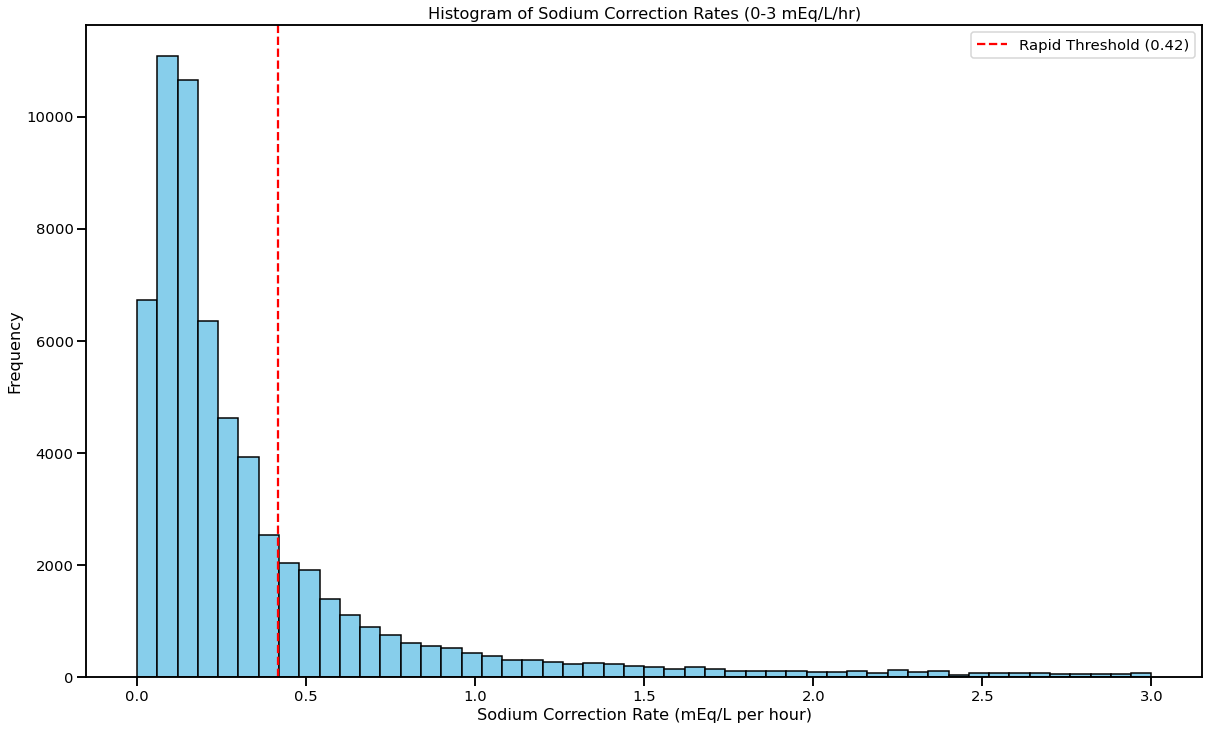

In [ ]:
# Histogram of correction rates across all intervals (filtered to 0-3 mEq/L/hr)
plot_rates = sodium_rates[
    np.isfinite(sodium_rates['correction_rate']) &
    (sodium_rates['correction_rate'].between(0, 3))
].copy()

sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(20, 12))
plt.hist(plot_rates['correction_rate'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Sodium Correction Rate (mEq/L per hour)")
plt.ylabel("Frequency")
plt.title("Histogram of Sodium Correction Rates (0-3 mEq/L/hr)")
plt.axvline(rapid_threshold, color='red', linestyle='--', label=f'Rapid Threshold ({rapid_threshold:.2f})')
plt.legend()
plt.show()

### Conclusion
From the histogram, we see that while many patients experience slow-to-moderate sodium increases, rapid correction does occur in a portion of intervals. Incorporating a mechanism to prevent overly fast rises in serum sodium is vital for patient safety and should be considered in future hyponatremia treatment models.

## A4: Relationship Between Serum Sodium Levels and ICU Length of Stay
In this analysis, we load **serum sodium measurements** from the first 100 M rows of the MIMIC-IV `chartevents` table, merge them with **ICU length of stay (LOS) data** from `icustays`, and visualize their relationship. We first filter sodium values to valid `itemid`s within a plausible range (80–180 mEq/L), then merge these measurements with each patient's LOS via a simple join on `subject_id`. Finally, we plot a scatterplot of sodium (x-axis) vs. LOS (y-axis) to identify potential patterns.


Using serum sodium itemids: [220645, 226534, 228389, 228390]


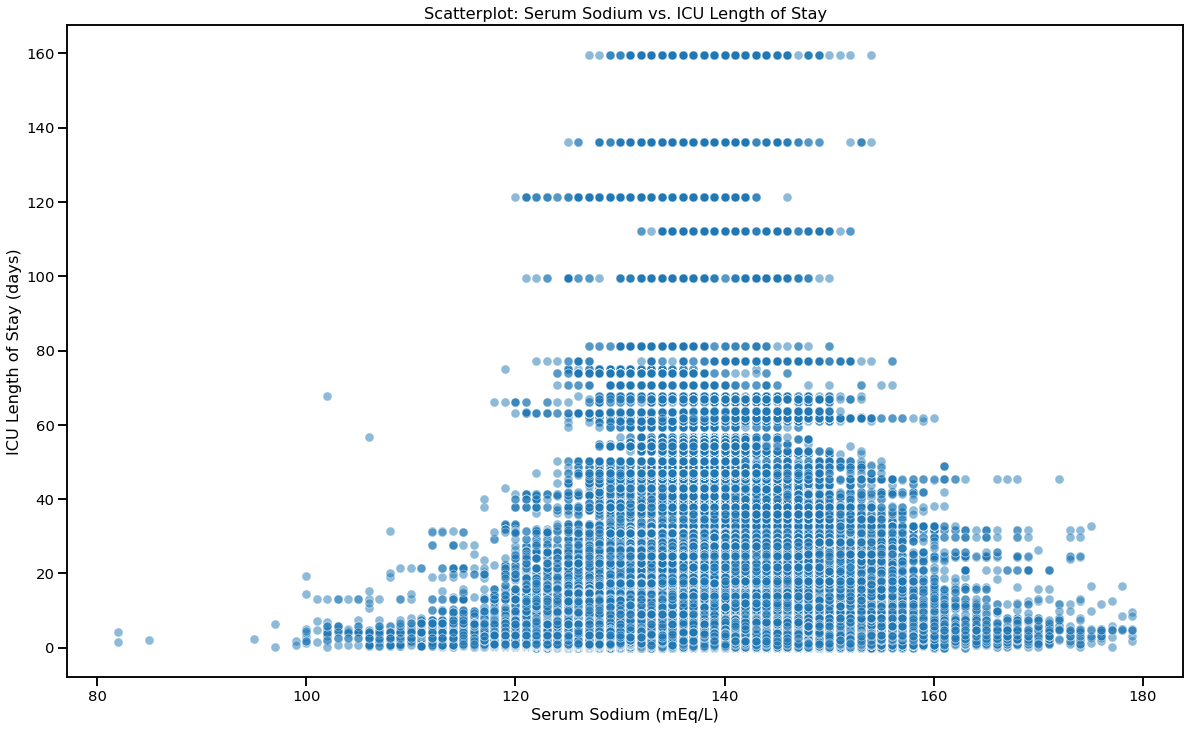

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths and project directories
mimic_path = "/home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/"
icu_path = os.path.join(mimic_path, "icu")
project_dir = os.path.join("/tmp", 'hyponatremia_analysis')
os.makedirs(project_dir, exist_ok=True)

# Specify itemids for serum sodium (MIMIC-IV known itemids)
serum_sodium_itemids = [220645, 226534, 228389, 228390]
print(f"Using serum sodium itemids: {serum_sodium_itemids}")

# Read the first 100M rows from chartevents.csv, focusing on relevant columns
chartevents_path = os.path.join(icu_path, "chartevents.csv")
df = pd.read_csv(chartevents_path, nrows=100000000, usecols=['subject_id', 'itemid', 'valuenum'])

# Filter for serum sodium measurements and plausible values
df_sodium = df[df['itemid'].isin(serum_sodium_itemids)]
df_sodium = df_sodium[df_sodium['valuenum'].notna() & (df_sodium['valuenum'] > 80) & (df_sodium['valuenum'] < 180)]

# Load icustays.csv to retrieve ICU length of stay (los)
icustays_path = os.path.join(icu_path, "icustays.csv")
icustays = pd.read_csv(icustays_path)


# Merge sodium measurements with icustays to bring in 'los'
df_sodium_los = pd.merge(df_sodium, icustays[['subject_id', 'los']], on='subject_id', how='left')

# Visualization: Scatterplot of Serum Sodium vs. ICU Length of Stay
sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(20, 12))
sns.scatterplot(data=df_sodium_los, x='valuenum', y='los', alpha=0.5)
plt.xlabel("Serum Sodium (mEq/L)")
plt.ylabel("ICU Length of Stay (days)")
plt.title("Scatterplot: Serum Sodium vs. ICU Length of Stay")
plt.show()

### Conclusion
- **Broad Distribution:** Most patients cluster around normal sodium values (roughly 130–145 mEq/L) with a wide range of ICU stays—anywhere from a few days up to 40+ days.  
- **Long Tails:** A minority of patients have either very high or very low sodium readings, but their LOS spans from short to quite prolonged, suggesting no simple linear correlation.  
- **No Clear Trend:** The scatter is relatively diffuse, implying that single sodium measurements alone are not strongly predictive of ICU length of stay. Multiple factors likely influence how long a patient remains in the ICU.

Overall, The broad scatter suggests there's not clear linear relationship between patients sodium level and their LOS. Additional variables or time-based trends may be needed to uncover stronger patterns.